<a href="https://colab.research.google.com/github/unkind58/Project_Football_Kits_Classifier/blob/main/football_kits_classifier_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install "torch==1.4" "torchvision==0.5.0"

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai import *
from fastai.vision import *

from google.colab import drive
from IPython.display import Image

Next step is setting random seed and mounting Google Drive where all images are stored

In [4]:
np.random.seed(seed=58)
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
path = Path('/content/gdrive/MyDrive/Projects/Data')
path_save = Path('/content/gdrive/MyDrive/Projects/models')

%cd /content/gdrive/MyDrive/Projects/Data

/content/gdrive/MyDrive/Projects/Data


Exploring what are the labels of each of folder


In [6]:
!ls

'ADO Den Haag'		  'Fortuna Sittard'	  'Sunderland AFC'
'Club Atletico Aldosivi'  'Manchester United FC'  'West Bromwich Albion FC'
'FC Nantes'		  'Norwich City FC'
'FC Neman Grodno'	  'Portland Timbers'


Setting Batch Size

In [7]:
bs = 8

Creating Image Data Bunch with normalization, dividing train and validation sets as 80/20.

In [8]:
dls = ImageDataBunch.from_folder(path,train=".",valid_pct=0.2,
                                  ds_tfms=get_transforms(), 
                                  seed=58,
                                  size=224, 
                                  num_workers=4, 
                                  bs=bs).normalize(imagenet_stats)

Classes amount, sets shapes and classes names.

In [9]:
print(f'Total training set image amount: {len(dls.train_ds)}')
print(f'Total validation set image amount: {len(dls.valid_ds)}')
print(f'Total classes number: {dls.c}')
print()
dls.classes

Total training set image amount: 196
Total validation set image amount: 48
Total classes number: 10



['ADO Den Haag',
 'Club Atletico Aldosivi',
 'FC Nantes',
 'FC Neman Grodno',
 'Fortuna Sittard',
 'Manchester United FC',
 'Norwich City FC',
 'Portland Timbers',
 'Sunderland AFC',
 'West Bromwich Albion FC']

Taking a look at a Valdiation set random Data Batch.

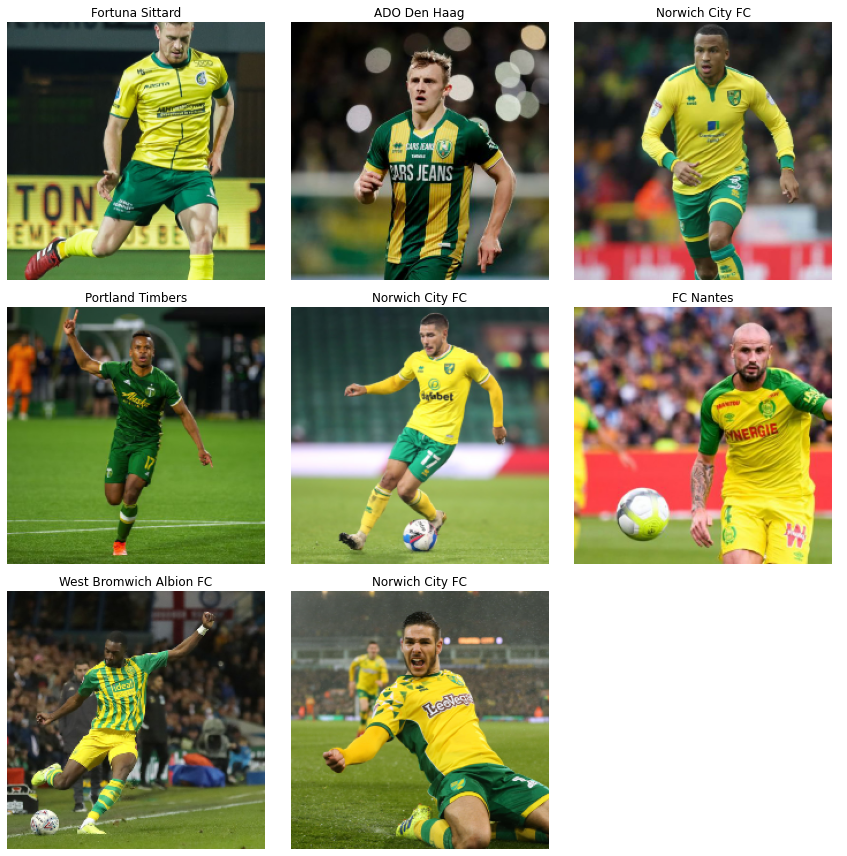

In [10]:
dls.show_batch(ds_type=DatasetType.Valid)

Initializing Convolutional Neural Network  using transfer learning with RESNET34 as a pretrained model. Evaluation metric is error rate.

In [11]:
learn = cnn_learner(dls,models.resnet34,metrics=error_rate)

Creating new derictory for storaging models.

In [12]:
learn.model_dir='/content/gdrive/MyDrive/Projects/models'
learn.path/learn.model_dir

PosixPath('/content/gdrive/MyDrive/Projects/models')

Running 6 epochs with .fit_one_cycle() method.

In [13]:
learn.fit_one_cycle(6)

Ground truth VS. Predictions

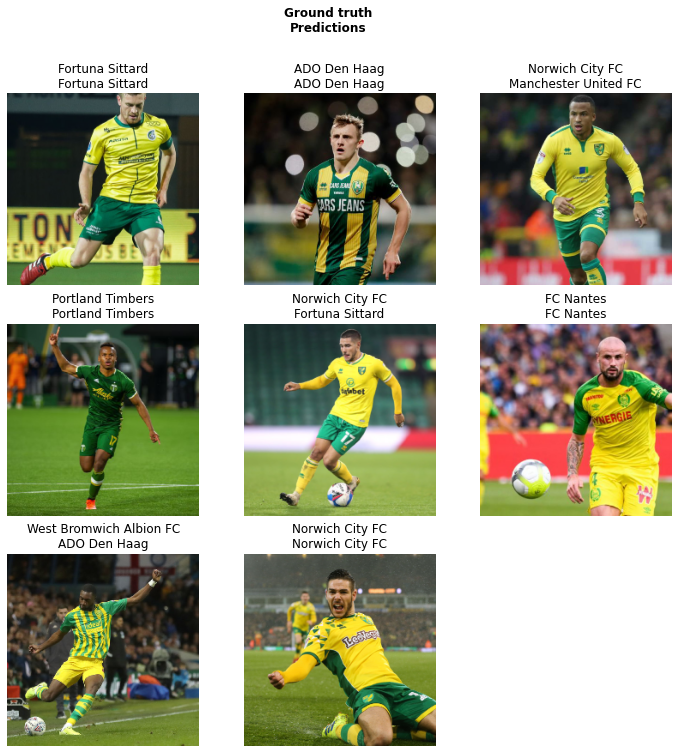

In [15]:
learn.show_results()

Saving first stage model, unfreezing last layers and finding optimal Learning rate.

In [15]:
learn.save('stage-1')

In [16]:
learn.unfreeze()

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [19]:
#  dls.valid_ds.items

Plotting Learning rate finder's computations.

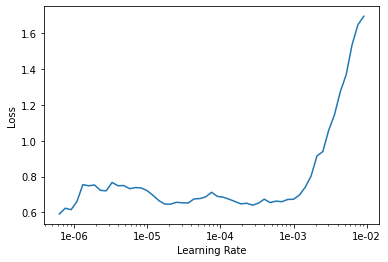

In [18]:
learn.recorder.plot()

Slicing Learning rate from 1e-4 to 3e-4.

In [19]:
learn.fit_one_cycle(5, max_lr=slice(1e-4,3e-4))

In [20]:
learn.save('stage-2')

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

Visualizing confusion matrix with all predictions

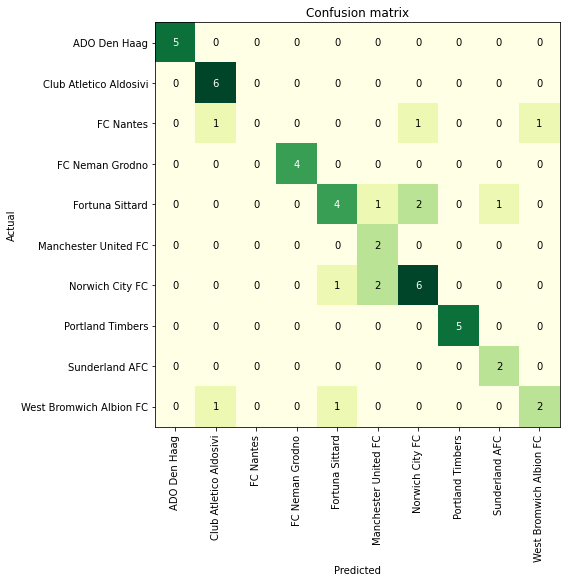

In [21]:
interp.plot_confusion_matrix(cmap='YlGn',figsize=(12,8))

Extracting images with heatmap effect which shows me what part of the image did the CNN focus on.

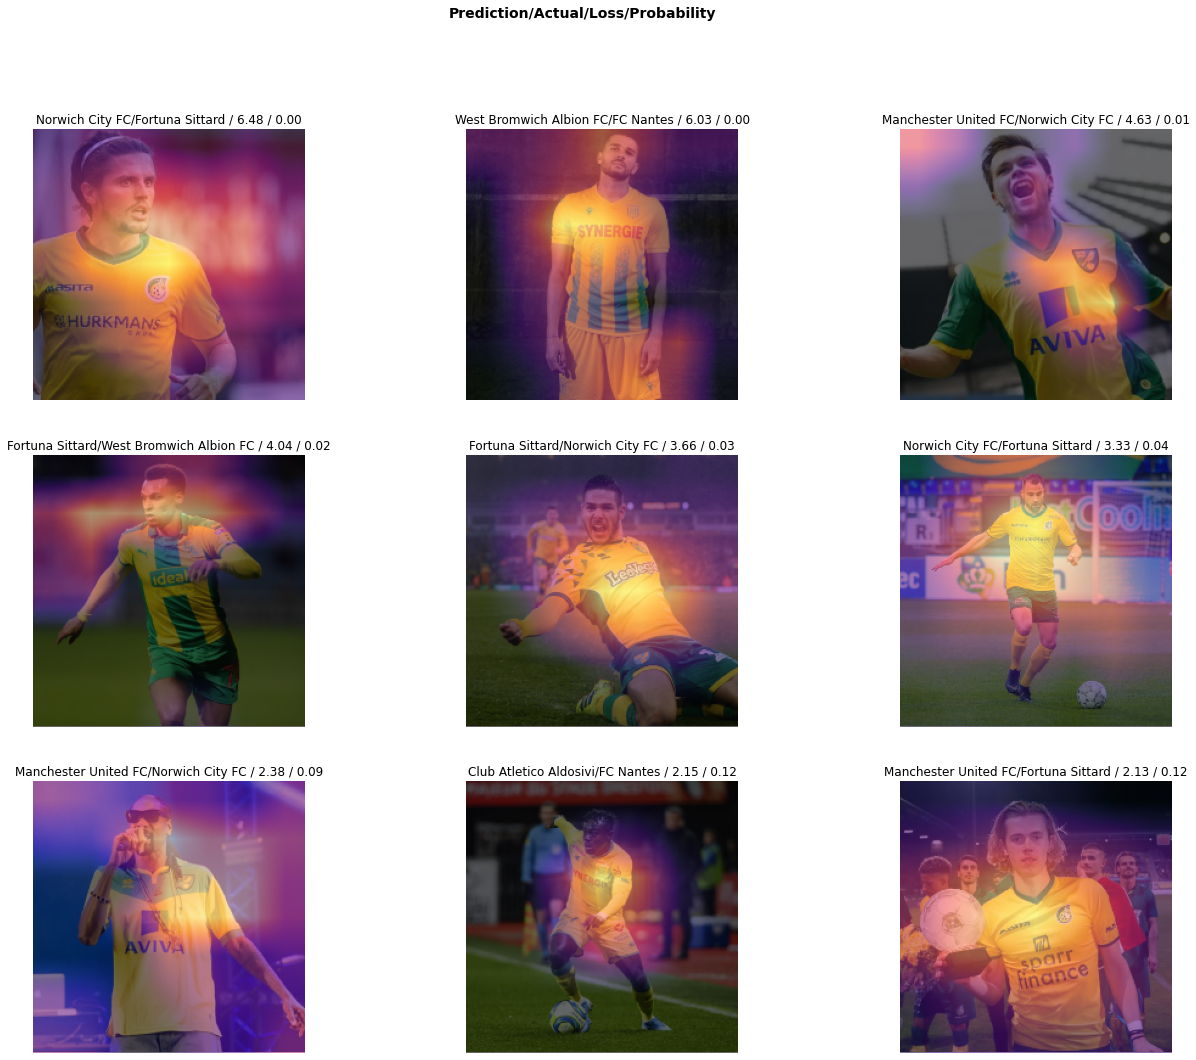

In [22]:
interp.plot_top_losses(9, figsize=(22,17),heatmap=True)

List of recognition mistakes with threshold of minimum 1 mistake per pair.

In [23]:
interp.most_confused(min_val=1)

[('Fortuna Sittard', 'Norwich City FC', 2),
 ('Norwich City FC', 'Manchester United FC', 2),
 ('FC Nantes', 'Club Atletico Aldosivi', 1),
 ('FC Nantes', 'Norwich City FC', 1),
 ('FC Nantes', 'West Bromwich Albion FC', 1),
 ('Fortuna Sittard', 'Manchester United FC', 1),
 ('Fortuna Sittard', 'Sunderland AFC', 1),
 ('Norwich City FC', 'Fortuna Sittard', 1),
 ('West Bromwich Albion FC', 'Club Atletico Aldosivi', 1),
 ('West Bromwich Albion FC', 'Fortuna Sittard', 1)]

In [24]:
learn.unfreeze()

In [34]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


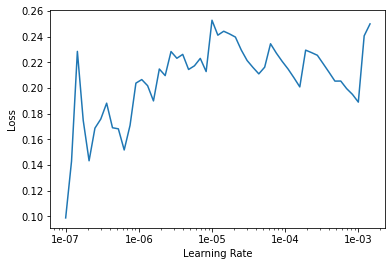

In [36]:
learn.recorder.plot(skip_start=0, skip_end=5) 

In [37]:
learn.fit_one_cycle(5, max_lr=1e-7) # how to stop at exact or can I laod and get back

Overfitting as Validation error is high, training rather error low, so lets use weight decay

In [ ]:
learn.load('stage-2')

In [44]:
learn.unfreeze()

In [45]:
learn.fit_one_cycle(4, max_lr=1e-7,wd=0.2) 

In [32]:
learn.save('stage-3')

Trying  image augmentation

In [46]:
tfms = get_transforms(do_flip=False,max_rotate=10.,max_zoom=1.3,max_lighting=0.4, 
                      max_warp=0.1, p_affine=1., p_lighting=1.,)

In [47]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=58);src

ItemLists;

Train: ImageList (196 items)
Image (3, 2897, 1936),Image (3, 594, 401),Image (3, 612, 377),Image (3, 761, 564),Image (3, 612, 410)
Path: /content/gdrive/MyDrive/Projects/Data;

Valid: ImageList (48 items)
Image (3, 1888, 1152),Image (3, 410, 615),Image (3, 765, 1360),Image (3, 531, 800),Image (3, 691, 1024)
Path: /content/gdrive/MyDrive/Projects/Data;

Test: None

In [48]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_folder()).transform(tfms, size=size, padding_mode=padding_mode).databunch(bs=bs).normalize(imagenet_stats)

In [49]:
data_augm = get_data(224, bs)

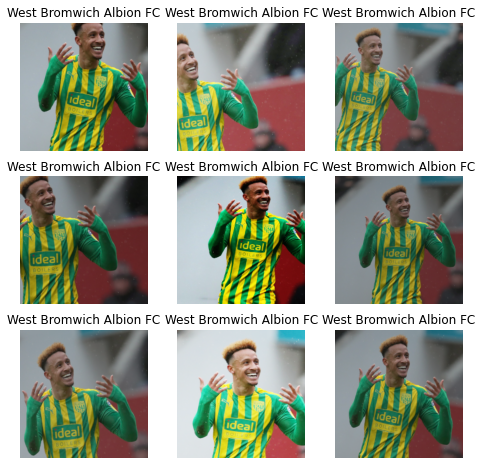

In [53]:
def _plot(i,j,ax):
    x,y = data_augm.train_ds[58]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [54]:
gc.collect()

17222

In [55]:
print(f'Total training set image amount: {len(data_augm.train_ds)}')
print(f'Total validation set image amount: {len(data_augm.valid_ds)}')

Total training set image amount: 196
Total validation set image amount: 48


In [56]:
learn_augm = cnn_learner(data_augm, models.resnet34, metrics=error_rate)

In [57]:
learn_augm.fit_one_cycle(5)

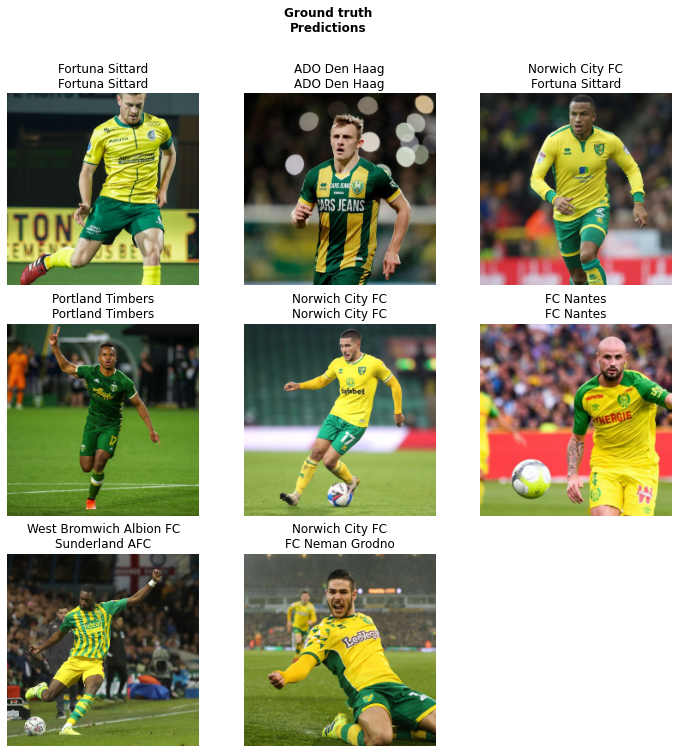

In [58]:
learn_augm.show_results()

In [59]:
learn_augm.unfreeze()

In [60]:
learn_augm.fit_one_cycle(12, pct_start=0.8)

Unknown fit - Validation error low, training error 'high'

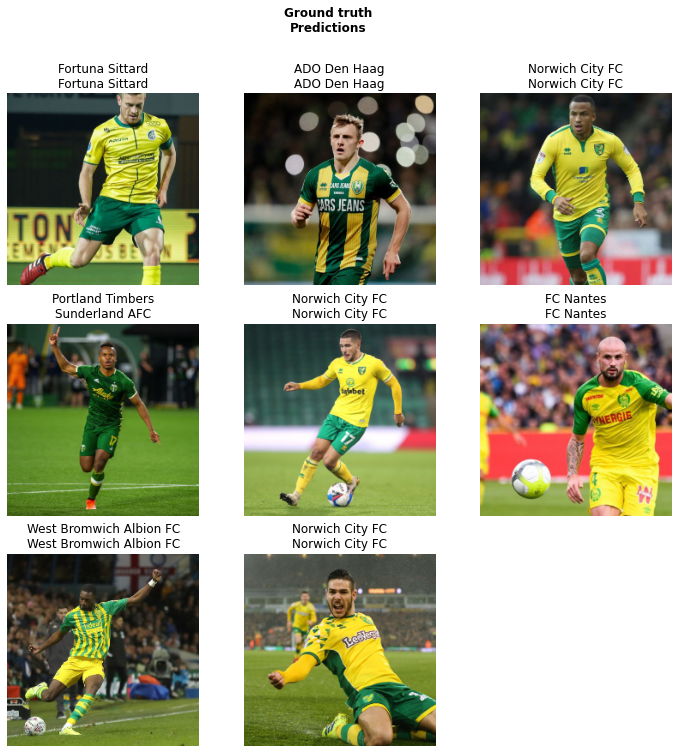

In [62]:
learn_augm.show_results()

In [63]:
learn_augm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


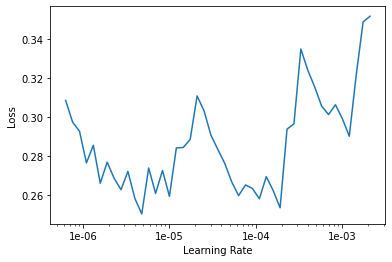

In [64]:
learn_augm.recorder.plot()

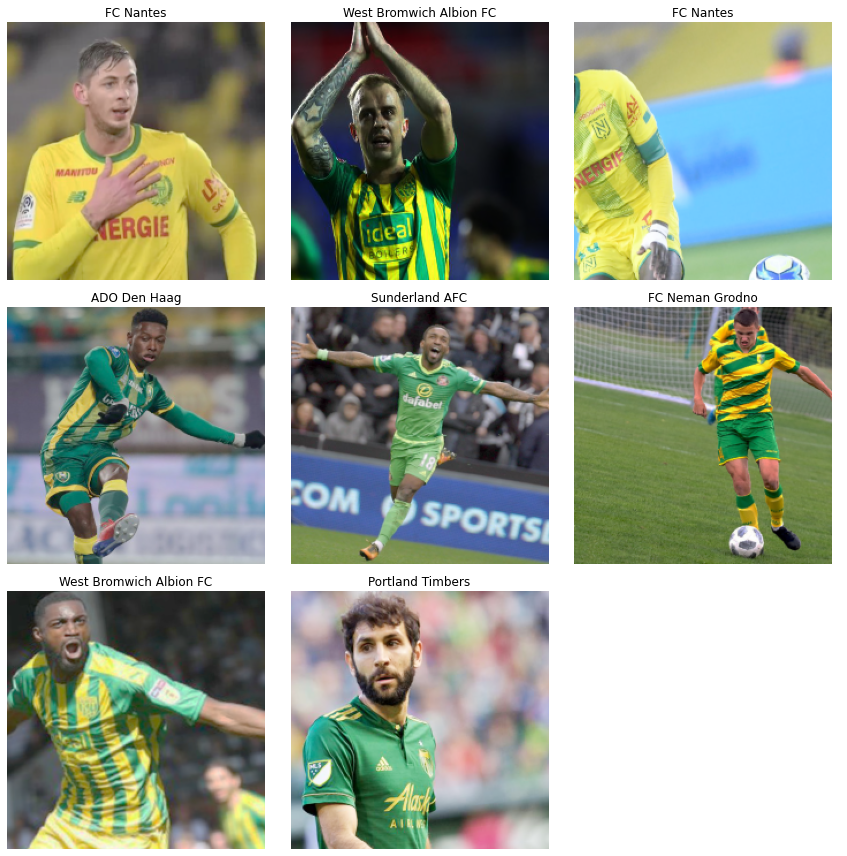

In [65]:
data_augm.show_batch(ds_type=DatasetType.Train)

In [66]:
interp_augm = ClassificationInterpretation.from_learner(learn_augm)

In [67]:
interp_augm.most_confused(min_val=1)

[('West Bromwich Albion FC', 'Club Atletico Aldosivi', 2),
 ('Fortuna Sittard', 'Norwich City FC', 1),
 ('Norwich City FC', 'FC Nantes', 1),
 ('Norwich City FC', 'Fortuna Sittard', 1),
 ('Portland Timbers', 'Sunderland AFC', 1)]

'Fortuna Sittard' is the mostly unpredictable type, along with 'Norwich City FC'

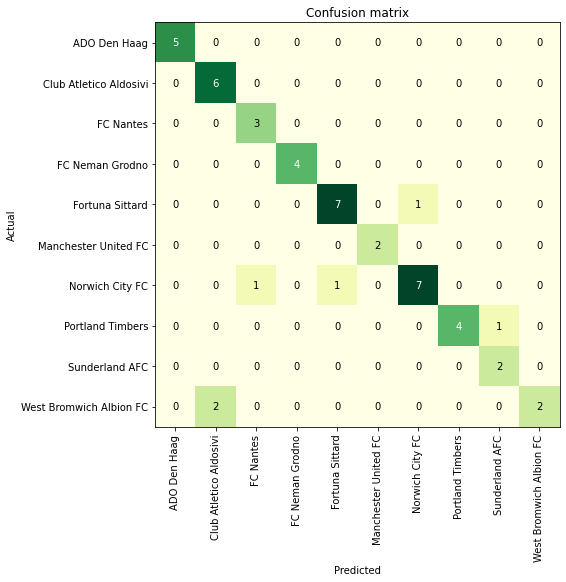

In [68]:
interp_augm.plot_confusion_matrix(cmap='YlGn',figsize=(12,8))

So still unknown future steps as validation loss in lower than training loss, quite counterintuitive